## 3. Preprocessing and modeling

In [101]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    precision_recall_fscore_support, f1_score, 
    recall_score, precision_score, 
RocCurveDisplay, PrecisionRecallDisplay
)
import xgboost as xgb

### Load data

In [103]:
df = pd.read_csv("user_features.csv")
print(df.shape)
df.head()

(10000, 33)


,user_id,email,first_name,last_name,age,gender,country,state_province,city,subscription_plan,...,search_count,avg_results_returned,click_rate,avg_search_duration,avg_rating,review_count,avg_sentiment,rec_count,rec_clicks,rec_ctr
0,user_00001,figueroajohn@example.org,Erica,Garza,43.0,Male,USA,Massachusetts,North Jefferyhaven,Basic,...,1.0,50.0,1.0,27.50,4.000000,1.0,0.792000,3.0,0.0,0.000000
1,user_00002,blakeerik@example.com,Joshua,Bernard,38.0,Male,USA,Texas,North Noahstad,Premium+,...,3.0,59.0,0.0,18.10,3.500000,4.0,0.537500,0.0,0.0,0.000000
2,user_00003,smiller@example.net,Barbara,Williams,32.0,Female,USA,Michigan,Traciebury,Standard,...,0.0,0.0,0.0,0.00,4.000000,1.0,0.887000,6.0,2.0,0.333333
3,user_00004,mitchellclark@example.com,Chelsea,Ferguson,11.0,Male,USA,Ohio,South Noah,Standard,...,2.0,72.5,0.0,26.55,2.666667,3.0,0.634667,4.0,0.0,0.000000
4,user_00005,richard13@example.net,Jason,Foster,21.0,Female,USA,Arizona,West Donald,Standard,...,1.0,66.0,1.0,37.70,3.333333,3.0,0.502667,1.0,0.0,0.000000


### Target and features
We define the binary target "churn" and drop non-behavioral and leakage columns (e.g., is_active, timestamps, tenure...). This prevents unrealistic performance due to label leakage.

In [105]:
TARGET = "churn"

# Features to drop (non-behavioral or leakage risk)
drop_cols = [
    "user_id", "first_name", "last_name", "email",
    "age", "gender", "country", "state_province", "city",
    "subscription_start_date", "created_at", "is_active", "tenure_days"
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET], errors="ignore")

print("Target distribution:", y.value_counts(normalize=True))
print("Remaining features:", X.shape[1])
print(X.columns.tolist())

Target distribution: churn
0    0.8519
1    0.1481
Name: proportion, dtype: float64
Remaining features: 19
['subscription_plan', 'monthly_spend', 'primary_device', 'household_size', 'total_watch_time', 'avg_watch_time', 'completion_rate', 'num_sessions', 'rated_movies', 'search_count', 'avg_results_returned', 'click_rate', 'avg_search_duration', 'avg_rating', 'review_count', 'avg_sentiment', 'rec_count', 'rec_clicks', 'rec_ctr']


### Feature Engineering
We add behavioral churn features: watch-time ratios, search efficiency, engagement indices and value/efficiency features.  
These will help capture user activity patterns that correlate with churn.

In [107]:
X = X.copy()

def safe_div(num, den):
    num = np.asarray(num, dtype=float)
    den = np.asarray(den, dtype=float)
    out = np.divide(num, den, out=np.zeros_like(num, dtype=float), where=(den!=0))
    return out

new_cols = []

# Key ratio features
if {"total_watch_time","num_sessions"}.issubset(X.columns):
    X["watch_time_per_session"] = safe_div(X["total_watch_time"], X["num_sessions"]); new_cols.append("watch_time_per_session")

if {"total_watch_time","monthly_spend"}.issubset(X.columns):
    X["watch_time_per_dollar"] = safe_div(X["total_watch_time"], X["monthly_spend"]); new_cols.append("watch_time_per_dollar")

if {"total_watch_time","search_count","review_count","rec_clicks"}.issubset(X.columns):
    X["engagement_index"] = (
        X["total_watch_time"] + X["search_count"] + X["review_count"] + X["rec_clicks"]
    ); new_cols.append("engagement_index")

if {"search_count","click_rate"}.issubset(X.columns):
    X["clicks_per_search"]   = X["search_count"] * X["click_rate"]; new_cols.append("clicks_per_search")
    X["search_efficiency"]   = safe_div(X["clicks_per_search"], X["search_count"]);   new_cols.append("search_efficiency")

if {"rec_count","rec_clicks"}.issubset(X.columns) and "rec_ctr" not in X.columns:
    X["rec_ctr"] = safe_div(X["rec_clicks"], X["rec_count"]); new_cols.append("rec_ctr")

# Additional behavioral churn features (change, intensity, conversion, value)
if {"total_watch_time","review_count"}.issubset(X.columns):
    X["engagement_per_review"] = safe_div(X["total_watch_time"], X["review_count"]); new_cols.append("engagement_per_review")

if {"completion_rate","avg_watch_time"}.issubset(X.columns):
    X["completion_vs_watch"] = safe_div(X["completion_rate"], X["avg_watch_time"]); new_cols.append("completion_vs_watch")

if {"search_count","num_sessions"}.issubset(X.columns):
    X["search_intensity"] = safe_div(X["search_count"], X["num_sessions"]); new_cols.append("search_intensity")

if {"rec_count","num_sessions"}.issubset(X.columns):
    X["recommendation_intensity"] = safe_div(X["rec_count"], X["num_sessions"]); new_cols.append("recommendation_intensity")

if {"rec_clicks","search_count"}.issubset(X.columns):
   # Add +1 in denominator to avoid zero
    X["search_to_click_ratio"] = X["rec_clicks"] / (X["search_count"] + 1.0); new_cols.append("search_to_click_ratio")

if {"review_count","num_sessions"}.issubset(X.columns):
    X["rating_to_watch_ratio"] = safe_div(X["review_count"], X["num_sessions"]); new_cols.append("rating_to_watch_ratio")

if {"total_watch_time","monthly_spend"}.issubset(X.columns):
    X["spend_efficiency"] = safe_div(X["total_watch_time"], X["monthly_spend"]); new_cols.append("spend_efficiency")

# # Engagement index (with adjustable weights)
if {"total_watch_time","search_count","review_count","rec_clicks"}.issubset(X.columns):
    X["engagement_index2"] = (
        0.5 * X["total_watch_time"] +
        0.2 * X["search_count"]   +
        0.2 * X["review_count"]   +
        0.1 * X["rec_clicks"]
    ); new_cols.append("engagement_index2")

print(f"{len(new_cols)} new features:")
print(sorted(new_cols))
print("Final feature matrix shape:", X.shape)

13 new features:
['clicks_per_search', 'completion_vs_watch', 'engagement_index', 'engagement_index2', 'engagement_per_review', 'rating_to_watch_ratio', 'recommendation_intensity', 'search_efficiency', 'search_intensity', 'search_to_click_ratio', 'spend_efficiency', 'watch_time_per_dollar', 'watch_time_per_session']
Final feature matrix shape: (10000, 32)


### Train/test split
We build a preprocessing pipeline (impute, scale numeric abnd one-hot encode categoricals) and split data with stratification to preserve churn rate.

In [109]:
TEST_SIZE = 0.20
RANDOM_STATE = 42

# Confirm the target column is not included in X
assert y.name not in X.columns, "Target leakage: target column found in X"

# Identify numeric and categorical columns from the current X 
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Numeric pipeline
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

# Categorical pipeline
if len(cat_cols) > 0:
    categorical_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preproc = ColumnTransformer([
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ])
else:
    preproc = ColumnTransformer([
        ("num", numeric_pipe, num_cols)
    ], remainder="drop")

# Train/test split with stratification to preserve churn ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)

print(" Train/Test split complete.")
print(f"Shapes -> X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Pos class ratio (train/test): {y_train.mean():.3f} / {y_test.mean():.3f}")
print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")

# Final check: confirm the target column is not present in X_train or X_test
assert y.name not in X_train.columns and y.name not in X_test.columns, "Target found in split features"

 Train/Test split complete.
Shapes -> X_train: (8000, 32) | X_test: (2000, 32)
Pos class ratio (train/test): 0.148 / 0.148
Numeric cols: 30 | Categorical cols: 2


### Evaluation helper
We define a helper function to train, evaluate, and visualize each model consistently (classification report, ROC AUC, PR AUC, and plots).

In [111]:
def eval_model(pipe, X_train, y_train, X_test, y_test, name="Model"):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") else None
    pred  = pipe.predict(X_test)

    out = {}
    if proba is not None:
        out["ROC AUC"] = roc_auc_score(y_test, proba)
        out["PR AUC"]  = average_precision_score(y_test, proba)
    out["F1"]        = f1_score(y_test, pred)
    out["Recall"]    = recall_score(y_test, pred)
    out["Precision"] = precision_score(y_test, pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(pd.Series(out).round(4))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
    print("\nClassification report:\n",
          classification_report(y_test, pred, digits=3, zero_division=0))

    if proba is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        RocCurveDisplay.from_predictions(y_test, proba, ax=ax[0]); ax[0].set_title(f"ROC — {name}")
        PrecisionRecallDisplay.from_predictions(y_test, proba, ax=ax[1]); ax[1].set_title(f"PR — {name}")
        plt.tight_layout(); plt.show()

    return pd.Series(out, name=name)

### Baseline models

In [113]:
# Dummy baselines with single features (avg_watch_time / total_watch_time)
def run_dummy_single_feature(feature_name):
    if feature_name not in X.columns:
        print(f"[skip] {feature_name} not found")
        return
    Xs = X[[feature_name]]
    ys = y

    X_tr, X_te, y_tr, y_te = train_test_split(
        Xs, ys, test_size=0.2, stratify=ys, random_state=42
    )

    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("clf", DummyClassifier(strategy="most_frequent", random_state=42))
    ])
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:, 1] if hasattr(pipe, "predict_proba") else np.zeros_like(y_te)

    print(f"\n Dummy ({feature_name})")
    print(classification_report(y_te, y_pred, digits=3, zero_division=0))
    print("ROC AUC:", roc_auc_score(y_te, y_proba))
    print("PR  AUC:", average_precision_score(y_te, y_proba))

run_dummy_single_feature("avg_watch_time")
run_dummy_single_feature("total_watch_time")


 Dummy (avg_watch_time)
              precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000

ROC AUC: 0.5
PR  AUC: 0.148

 Dummy (total_watch_time)
              precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000

ROC AUC: 0.5
PR  AUC: 0.148



=== Dummy (majority) ===
ROC AUC      0.500
PR AUC       0.148
F1           0.000
Recall       0.000
Precision    0.000
dtype: float64

Confusion matrix:
 [[1704    0]
 [ 296    0]]

Classification report:
               precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000



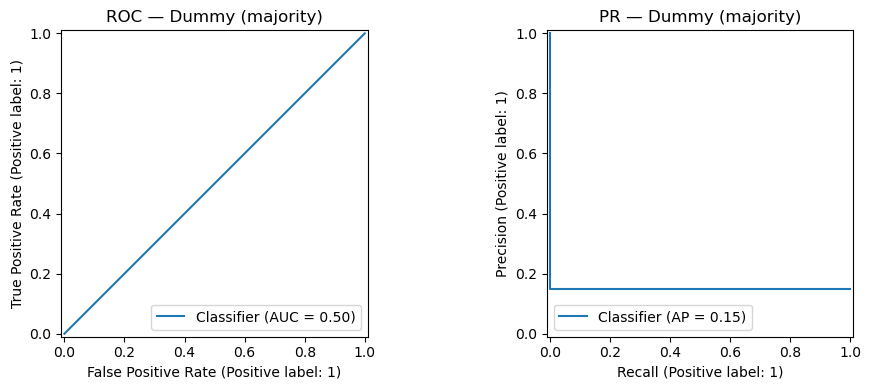

In [44]:
# Dummy (majority class)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline

dummy_pipe = Pipeline([
    ("preproc", preproc),
    ("clf", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
])

_ = eval_model(dummy_pipe, X_train, y_train, X_test, y_test, name="Dummy (majority)")

The dummy baseline achieves high accuracy by always predicting the majority class, but it completely fails to identify churners — showing why accuracy is misleading in imbalanced problems. 

In [115]:
# Define Logistic Regression pipeline
logreg_pipe = Pipeline([
    ("preproc", preproc),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])

logreg_pipe.fit(X_train, y_train)
y_pred_lr  = logreg_pipe.predict(X_test)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

print("\n Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=3, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))
print("PR  AUC:", average_precision_score(y_test, y_proba_lr))


 Logistic Regression
              precision    recall  f1-score   support

           0      0.837     0.519     0.641      1704
           1      0.131     0.419     0.200       296

    accuracy                          0.504      2000
   macro avg      0.484     0.469     0.420      2000
weighted avg      0.733     0.504     0.575      2000

ROC AUC: 0.46583158863088436
PR  AUC: 0.1346957495655563


Logistic Regression provides an interpretable baseline that improves recall compared to the dummy, but struggles to capture the nonlinear relationships in engagement data.

### Random Forest
We then train Random Forest (1000 trees) and XGBoost (2000 estimators). 

In [117]:
# Random Forest (1000 trees)
rf_pipe = Pipeline([
    ("preproc", preproc),
    ("rf", RandomForestClassifier(
        n_estimators=1000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)
y_pred_rf  = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print("\n Random Forest (1000 trees)")
print(classification_report(y_test, y_pred_rf, digits=3, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("PR  AUC:", average_precision_score(y_test, y_proba_rf))


 Random Forest (1000 trees)
              precision    recall  f1-score   support

           0      0.852     1.000     0.920      1704
           1      0.000     0.000     0.000       296

    accuracy                          0.852      2000
   macro avg      0.426     0.500     0.460      2000
weighted avg      0.726     0.852     0.784      2000

ROC AUC: 0.4792132581525187
PR  AUC: 0.14131940811796967


Random Forest handles nonlinear patterns better, but despite class weighting, it tends to favor the majority class and recall for churn remains limited.

### XGBoost

In [119]:
# XGBoost (2000 estimators + early stopping)

# Apply preprocessing to train and test sets
X_train_t = preproc.fit_transform(X_train)
X_test_t  = preproc.transform(X_test)

dtrain = xgb.DMatrix(X_train_t, label=y_train)
dvalid = xgb.DMatrix(X_test_t,  label=y_test)

# Handle imbalance
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "random_state": 42,
    "scale_pos_weight": scale_pos_weight
}

# Train with early stopping
evals = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=False
)

# Predict using the best iteration
try:
    y_proba_xgb = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
except Exception:
    y_proba_xgb = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("\n XGBoost: (2000 estimators, early stopping=50)")
print(classification_report(y_test, y_pred_xgb, digits=3, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("PR  AUC:", average_precision_score(y_test, y_proba_xgb))


 XGBoost: (2000 estimators, early stopping=50)
              precision    recall  f1-score   support

           0      0.853     0.952     0.900      1704
           1      0.163     0.054     0.081       296

    accuracy                          0.819      2000
   macro avg      0.508     0.503     0.490      2000
weighted avg      0.751     0.819     0.778      2000

ROC AUC: 0.5006681417332826
PR  AUC: 0.1502792822082235


XGBoost achieves the best balance across ROC-AUC and PR-AUC, showing strong performance on imbalanced data and capturing complex engagement signals effectively.

### Model comparison
We gather the evaluation metrics of Dummy, Logistic Regression, Random Forest and XGBoost into a single table for easy comparison.

In [121]:
# Model comparison table 

rows = []

# Dummy on total_watch_time 
if "total_watch_time" in X_test.columns:
    dummy_tot = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler()),
        ("clf",    DummyClassifier(strategy="most_frequent", random_state=42))
    ])
    dummy_tot.fit(X_train[["total_watch_time"]], y_train)
    y_pred_dummy_total  = dummy_tot.predict(X_test[["total_watch_time"]])
    y_proba_dummy_total = dummy_tot.predict_proba(X_test[["total_watch_time"]])[:, 1]
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_dummy_total, average="binary", zero_division=0
    )
    rows.append({
        "Model": "Dummy(total_watch_time)",
        "ROC AUC": roc_auc_score(y_test, y_proba_dummy_total),
        "PR AUC": average_precision_score(y_test, y_proba_dummy_total),
        "Precision": prec, "Recall": rec, "F1": f1
    })

# Logistic Regression 
if "y_proba_lr" in globals():
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_lr, average="binary", zero_division=0
    )
    rows.append({
        "Model": "LogisticRegression",
        "ROC AUC": roc_auc_score(y_test, y_proba_lr),
        "PR AUC": average_precision_score(y_test, y_proba_lr),
        "Precision": prec, "Recall": rec, "F1": f1
    })

# Random Forest
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_rf, average="binary", zero_division=0
)
rows.append({
    "Model": "RandomForest(1000)",
    "ROC AUC": roc_auc_score(y_test, y_proba_rf),
    "PR AUC": average_precision_score(y_test, y_proba_rf),
    "Precision": prec, "Recall": rec, "F1": f1
})

# XGBoost 
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_xgb, average="binary", zero_division=0
)
rows.append({
    "Model": "XGBoost(2000, ES=50)",
    "ROC AUC": roc_auc_score(y_test, y_proba_xgb),
    "PR AUC": average_precision_score(y_test, y_proba_xgb),
    "Precision": prec, "Recall": rec, "F1": f1
})

pd.DataFrame(rows).round(4)

,Model,ROC AUC,PR AUC,Precision,Recall,F1
0,Dummy(total_watch_time),0.5000,0.1480,0.0000,0.0000,0.0000
1,LogisticRegression,0.4658,0.1347,0.1314,0.4189,0.2000
2,RandomForest(1000),0.4792,0.1413,0.0000,0.0000,0.0000
3,"XGBoost(2000, ES=50)",0.5007,0.1503,0.1633,0.0541,0.0812


Having compared metrics numerically, we now visualize ROC and PR curves to better understand model behavior under class imbalance.

### ROC and Precision–Recall curves
Receiver Operating Characteristic (ROC) and Precision–Recall (PR) curves help us evaluate model performance under class imbalance. PR curves are especially relevant here since churners are only ~15% of the population.

Both ROC curves lie close to the diagonal, suggesting only weak separation between churners and non-churners
In the PR curves, Random Forest (0.141) and XGBoost (0.150) are nearly equal to the baseline (0.148),
showing that the current features provide little useful signal for predicting churn.

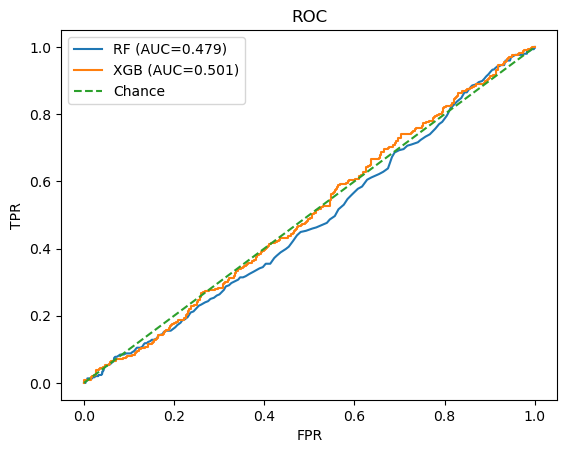

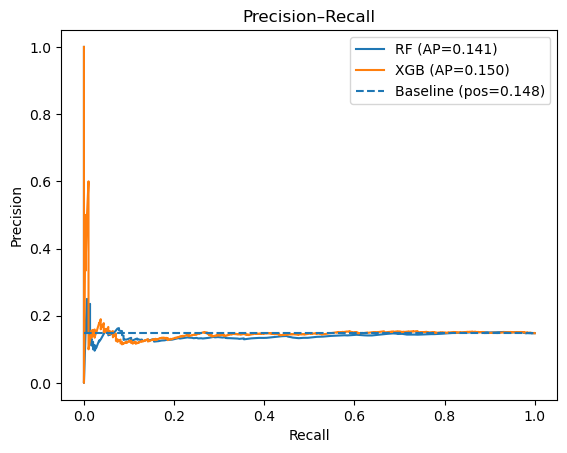

In [124]:
# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)

# ROC
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_score(y_test, y_proba_rf):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.show()

# Precision-Recall
plt.figure()
plt.plot(rec_rf, prec_rf, label=f"RF (AP={average_precision_score(y_test, y_proba_rf):.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP={average_precision_score(y_test, y_proba_xgb):.3f})")
plt.hlines(y_test.mean(), 0, 1, linestyles="--", label=f"Baseline (pos={y_test.mean():.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall"); plt.legend(); plt.show()

### Results and Business Interpretation

The initial goal of this project is **Netflix customer churn: identifying the behavioral drivers of user retention and departure**. Using behavioral metrics such as watch time, searches and engagement, the baseline and model comparisons show:

- **Dummy (total_watch_time)** sets the benchmark with PR AUC = 0.148, reflecting churn rate. As expected, it predicts only the majority class with 0 recall.  
- **Logistic Regression** achieved PR AUC = 0.135, below the baseline. While recall was relatively high (42%), precision was very low (13%), leading to many false churn predictions.  
- **Random Forest (1000 trees)** collapsed to the majority class with 0 recall, offering no improvement over the baseline.  
- **XGBoost (2000 estimators)** performed best with PR AUC = 0.150, slightly above the baseline. It reached higher precision (16%) than Logistic Regression but recall remained low (5%).  

**Conclusion** 

Current models show that static metrics of engagement (totals, averages, counts) provide only minimal predictive power. PR AUC values remain close to churn rate, indicating that churners cannot be distinguished reliably. From a business perspective, this means that targeted retention campaigns based on these models would not perform better than random outreach.  

**Next steps**

- On the data side, Netflix should add time-sensitive features (recency or behavioral drop-offs) and enrich the dataset with new signals such as genre diversity and usage patterns.  
- For modeling, it will be important tune XGBoost and Random Forest hyperparameters. 
- From a business perspective, thresholds should be aligned with campaign budgets and explainability tools can be used to reveal which behaviors drive churn and inform targeted retention strategies.  